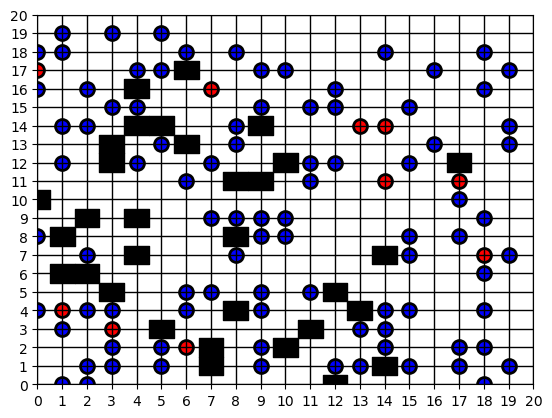

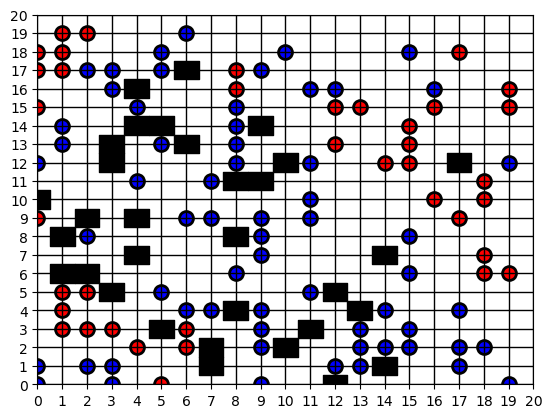

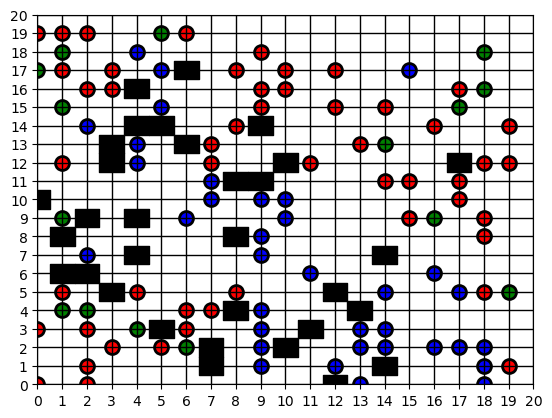

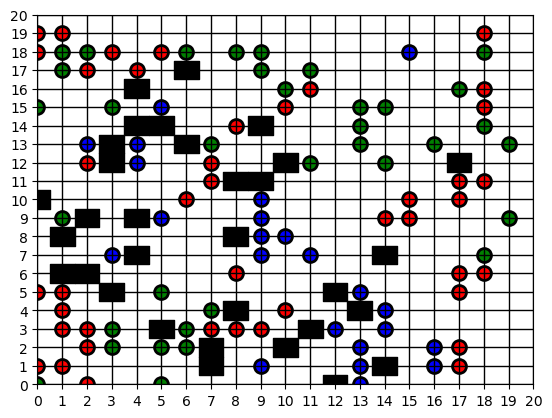

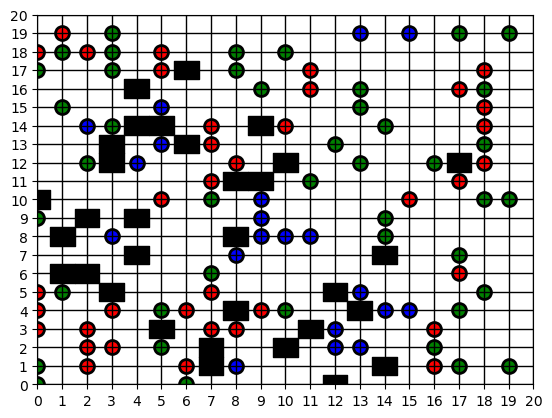

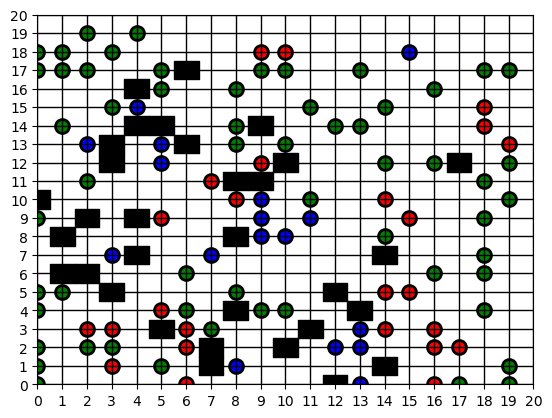

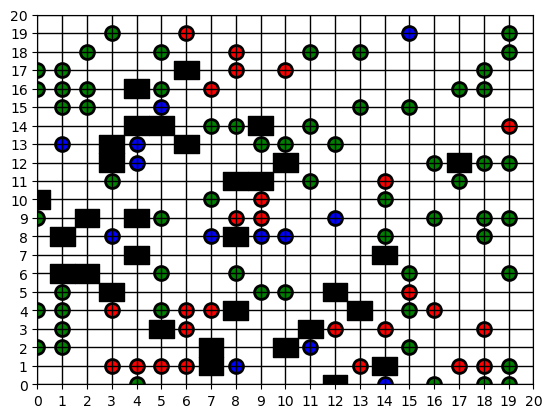

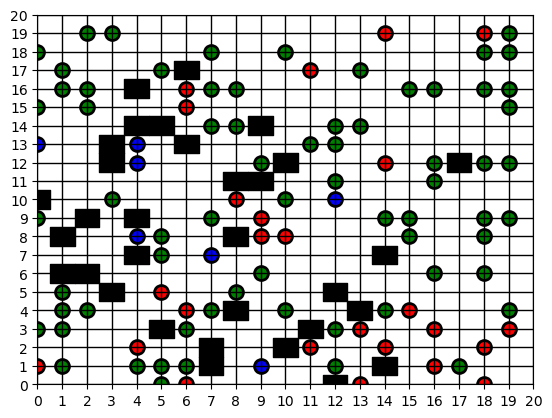

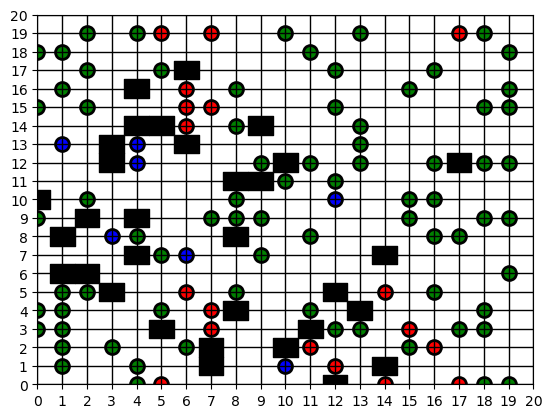

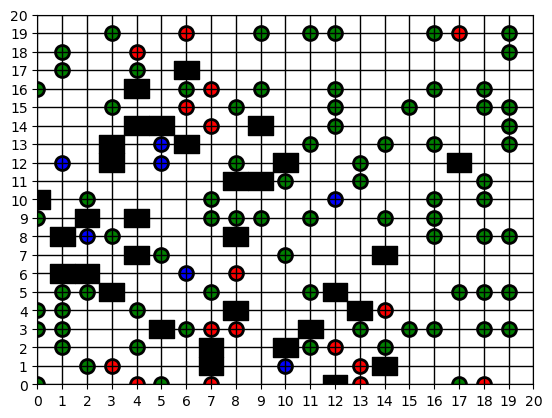

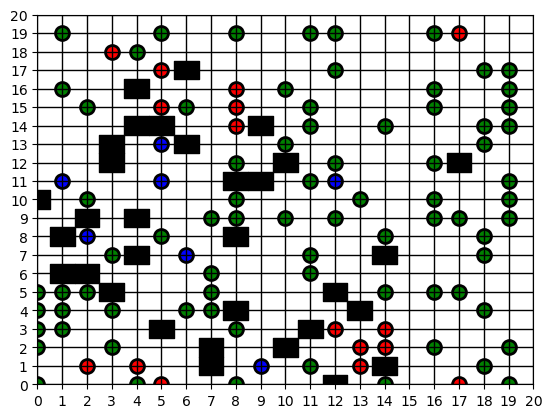

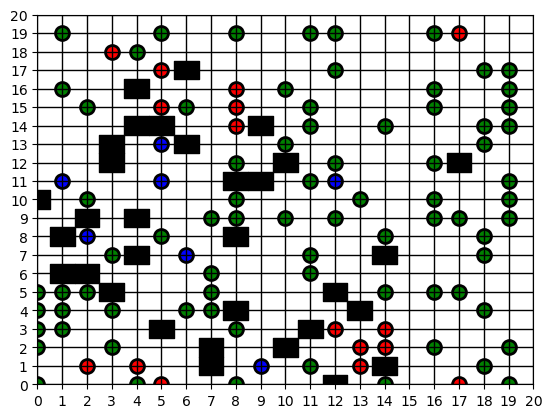

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random

class IndividualStatus:
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

def create_grid(rows, cols):
    grid = np.zeros((rows, cols), dtype=[('value', int), ('status', int), ('infection_duration', int)])
    return grid

def wrap_around_index(index, size):
    return (index + size) % size

def set_value(grid, row, col, value, status=0, infection_duration=0):
    rows, cols = grid.shape
    grid[row, col] = (value, status, infection_duration)

def get_point(grid, row, col):
    return grid[wrap_around_index(row, grid.shape[0]), wrap_around_index(col, grid.shape[1])]

def add_point(grid, row, col, value, status=0, infection_duration=0):
    set_value(grid, row, col, value, status, infection_duration)

def add_obstacle(grid, row, col):
    set_value(grid, row, col, value=-1)

def move_point(grid, current_row, current_col, other_positions, obstacles):
    move_direction = random.choice(['horizontal', 'vertical'])

    if move_direction == 'horizontal':
        new_col = wrap_around_index(current_col + random.choice([-1, 1]), grid.shape[1])
        new_position = (current_row, new_col)

        if grid[new_position]['value'] != -1 and new_position not in other_positions and new_position not in obstacles:
            return new_position
    elif move_direction == 'vertical':
        new_row = wrap_around_index(current_row + random.choice([-1, 1]), grid.shape[0])
        new_position = (new_row, current_col)

        if grid[new_position]['value'] != -1 and new_position not in other_positions and new_position not in obstacles:
            return new_position

    return current_row, current_col

def infect_neighbors(grid, row, col, max_distance=1, infection_probability=1, reinfection_probability=0.4, infection_duration=3):
    for i in range(-max_distance, max_distance + 1):
        for j in range(-max_distance, max_distance + 1):
            if i == 0 and j == 0:
                continue

            neighbor_row, neighbor_col = wrap_around_index(row + i, grid.shape[0]), wrap_around_index(col + j, grid.shape[1])

            neighbor_status = grid[neighbor_row, neighbor_col]['status']
            neighbor_infection_duration = grid[neighbor_row, neighbor_col]['infection_duration']

            if (
                max(abs(i), abs(j)) <= max_distance
                and neighbor_status == IndividualStatus.SUSCEPTIBLE
                and random.random() < infection_probability
            ):
                grid[neighbor_row, neighbor_col]['status'] = IndividualStatus.INFECTED
                grid[neighbor_row, neighbor_col]['infection_duration'] = infection_duration

            elif (
                max(abs(i), abs(j)) <= max_distance
                and neighbor_status == IndividualStatus.RECOVERED
                and random.random() < reinfection_probability
                and neighbor_infection_duration == 0
            ):
                grid[neighbor_row, neighbor_col]['status'] = IndividualStatus.INFECTED
                grid[neighbor_row, neighbor_col]['infection_duration'] = infection_duration


def plot_points(grid, point_positions):
    infected_positions = []
    susceptible_positions = []
    recovered_positions = []

    for (row, col) in point_positions:
        marker_size = 100
        value, status, _ = get_point(grid, row, col)

        if status == IndividualStatus.INFECTED:
            infected_positions.append((row, col))
        elif status == IndividualStatus.SUSCEPTIBLE:
            susceptible_positions.append((row, col))
        elif status == IndividualStatus.RECOVERED:
            recovered_positions.append((row, col))

    if susceptible_positions:
        susceptible_positions = np.array(susceptible_positions)
        plt.scatter(susceptible_positions[:, 1], susceptible_positions[:, 0], c='blue', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Susceptible')

    if infected_positions:
        infected_positions = np.array(infected_positions)
        plt.scatter(infected_positions[:, 1], infected_positions[:, 0], c='red', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Infected')

    if recovered_positions:
        recovered_positions = np.array(recovered_positions)
        plt.scatter(recovered_positions[:, 1], recovered_positions[:, 0], c='green', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Recovered')

    #plt.legend()

def plot_obstacles(grid):
    rows, cols = grid.shape
    for row in range(rows):
        for col in range(cols):
            if grid[row, col]['value'] == -1:
                plt.fill_between([col - 0.5, col + 0.5], row - 0.5, row + 0.5, color='black', alpha=1)

# Example usage
rows = 20
cols = 20
grid = create_grid(rows, cols)

num_points = 100

obstacle_positions = [
    (3, 5), (8, 8), (12, 3), (7, 4), (2, 10),
    (5, 12), (9, 2), (14, 9), (1, 7), (4, 13),
    (6, 1), (14, 4), (11, 8), (3, 11),
    (8, 1), (2, 7), (7, 14), (13, 6), (5, 3),
    (12, 10), (0, 12), (9, 4), (4, 8), (1, 14),
    (6, 2), (11, 9), (14, 5), (10, 0), (13, 3),
    (17, 6), (12, 17), (16, 4)
]

# Add obstacles to the grid
for obstacle_position in obstacle_positions:
    add_obstacle(grid, *obstacle_position)

# Randomized initial positions for people
point_positions = []
infection_percentage = 10  # Choose the desired percentage of infected individuals

for _ in range(num_points):
    while True:
        random_position = (random.randint(0, rows - 1), random.randint(0, cols - 1))
        if random_position not in obstacle_positions and random_position not in point_positions:
            point_positions.append(random_position)
            break

# Set initial infection status based on the chosen percentage
num_infected = int(num_points * (infection_percentage / 100))
infected_indices = random.sample(range(num_points), num_infected)

for i, position in enumerate(point_positions):
    is_infected = i in infected_indices
    add_point(grid, *position, value=i, status=IndividualStatus.INFECTED if is_infected else IndividualStatus.SUSCEPTIBLE, infection_duration=5 if is_infected else 0)  # Corrected infection duration

# Plot the initial grid and points
plt.xlim(0, cols)
plt.ylim(0, rows)
plt.xticks(np.arange(0, cols + 1, 1))
plt.yticks(np.arange(0, rows + 1, 1))
plt.grid(color='black', linestyle='-', linewidth=1)
plot_obstacles(grid)
plot_points(grid, point_positions)
plt.show()


# Simulation Loop
for step in range(10):
    plt.clf()

    for i, position in enumerate(point_positions.copy()):
        current_value, current_status, current_infection_duration = get_point(grid, *position)

        if current_status == IndividualStatus.INFECTED and current_infection_duration > 0:
            infect_neighbors(grid, *position)

        new_infection_duration = max(current_infection_duration - 1, 0)

        if current_status == IndividualStatus.INFECTED and new_infection_duration == 0:
            current_status = IndividualStatus.RECOVERED  # Newly infected individuals transition to the recovered state

        new_position = move_point(grid, *position, other_positions=point_positions[:i] + point_positions[i+1:], obstacles=obstacle_positions)

        # Clear the current position
        set_value(grid, *position, value=current_value, status=IndividualStatus.SUSCEPTIBLE, infection_duration=0)

        # Update the new position
        set_value(grid, *new_position, value=current_value, status=current_status, infection_duration=new_infection_duration)

        point_positions[i] = new_position

    for i in range(rows):
        for j in range(cols):
            if grid[i, j]['infection_duration'] > 0:
                grid[i, j]['infection_duration'] -= 1

    plt.xlim(0, cols)
    plt.ylim(0, rows)
    plt.xticks(np.arange(0, cols + 1, 1))
    plt.yticks(np.arange(0, rows + 1, 1))

    plt.grid(color='black', linestyle='-', linewidth=1)
    plot_obstacles(grid)
    plot_points(grid, point_positions)
    plt.show(block=False)
    plt.pause(0.1)

# Final state
plt.clf()
plt.xlim(0, cols)
plt.ylim(0, rows)
plt.xticks(np.arange(0, cols + 1, 1))
plt.yticks(np.arange(0, rows + 1, 1))
plt.grid(color='black', linestyle='-', linewidth=1)
plot_obstacles(grid)
plot_points(grid, point_positions)
plt.show()

In [9]:
pip install --upgrade matplotlib


  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\users\\rkesh\\anaconda3\\anaconda 3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.



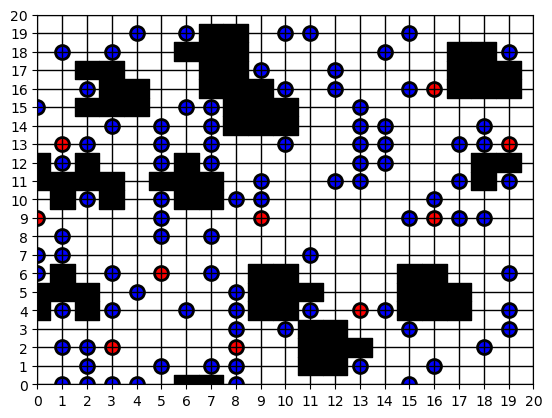

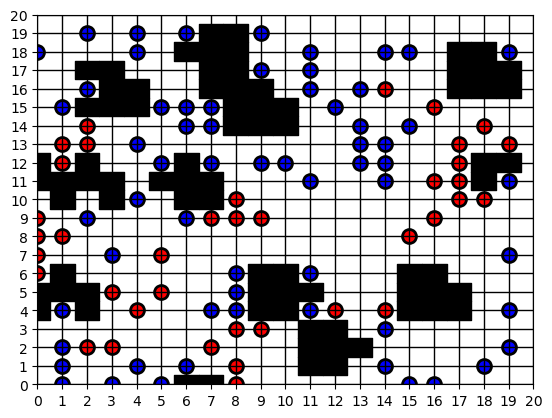

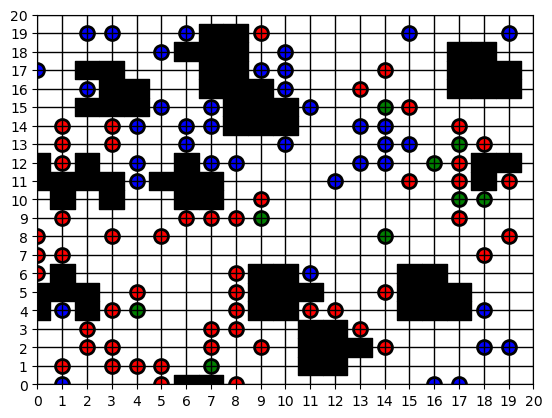

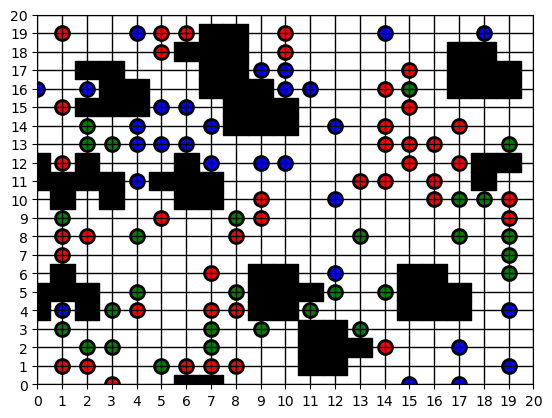

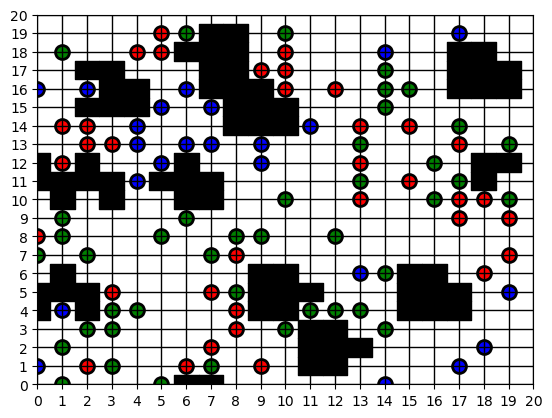

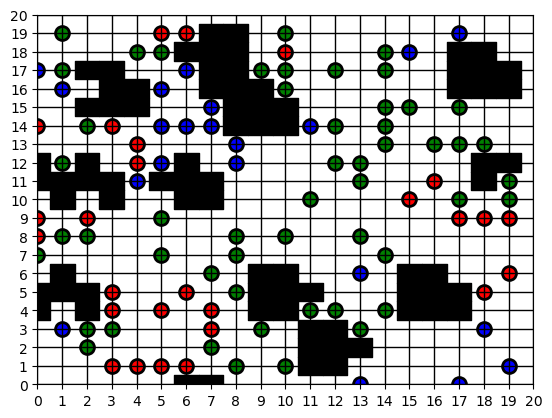

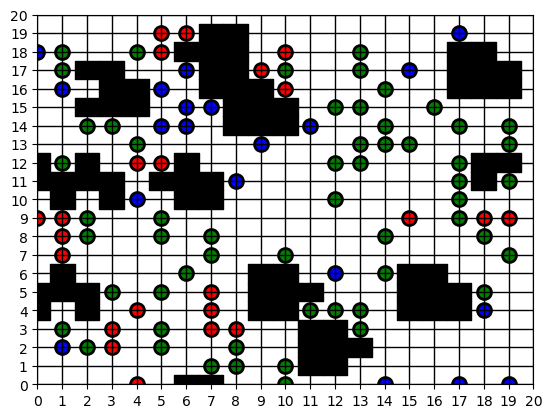

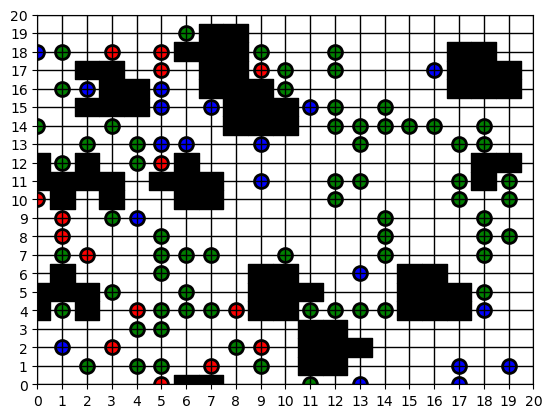

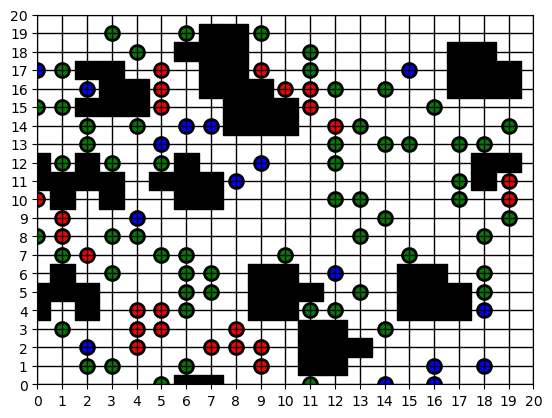

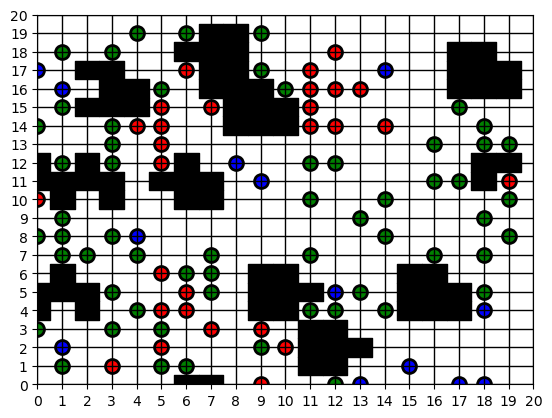

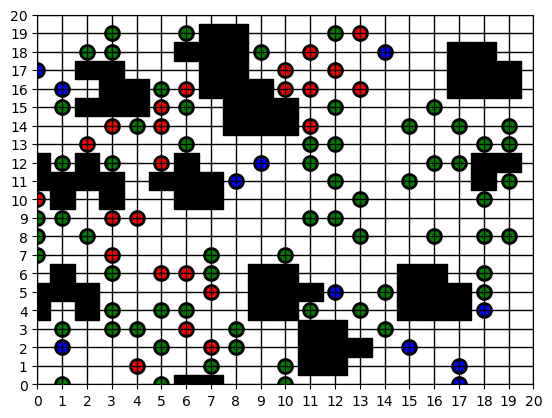

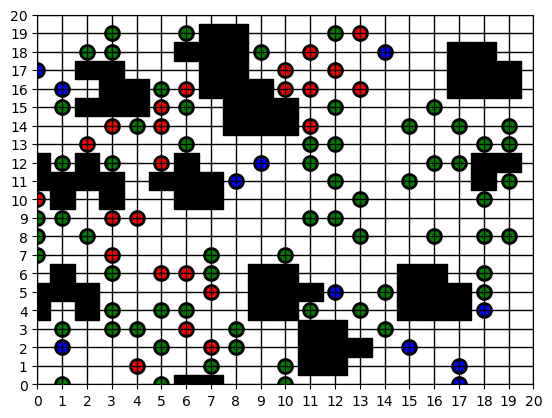

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random

class IndividualStatus:
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

def create_grid(rows, cols):
    grid = np.zeros((rows, cols), dtype=[('value', int), ('status', int), ('infection_duration', int)])
    return grid

def wrap_around_index(index, size):
    return (index + size) % size

def set_value(grid, row, col, value, status=0, infection_duration=0):
    rows, cols = grid.shape
    grid[row, col] = (value, status, infection_duration)

def get_point(grid, row, col):
    return grid[wrap_around_index(row, grid.shape[0]), wrap_around_index(col, grid.shape[1])]

def add_point(grid, row, col, value, status=0, infection_duration=0):
    set_value(grid, row, col, value, status, infection_duration)

def add_obstacle(grid, row, col, block_size=3):
    rows, cols = grid.shape
    
    # Create a vertical block
    for i in range(-block_size // 2, block_size // 2 + 1):
        set_value(grid, wrap_around_index(row + i, rows), col, value=-1)
    
    # Create a horizontal block
    for j in range(-block_size // 2, block_size // 2 + 1):
        set_value(grid, row, wrap_around_index(col + j, cols), value=-1)

    # Create additional horizontal blocks above and below
    for k in range(-block_size // 2, block_size // 2 + 1):
        set_value(grid, wrap_around_index(row - block_size, rows), wrap_around_index(col + k, cols), value=-1)
        set_value(grid, wrap_around_index(row + block_size, rows), wrap_around_index(col + k, cols), value=-1)

    # Create additional vertical blocks to the left and right
    for l in range(-block_size // 2, block_size // 2 + 1):
        set_value(grid, wrap_around_index(row + l, rows), wrap_around_index(col - block_size, cols), value=-1)
        set_value(grid, wrap_around_index(row + l, rows), wrap_around_index(col + block_size, cols), value=-1)


def move_point(grid, current_row, current_col, other_positions, obstacles):
    move_direction = random.choice(['horizontal', 'vertical'])

    if move_direction == 'horizontal':
        new_col = wrap_around_index(current_col + random.choice([-1, 1]), grid.shape[1])
        new_position = (current_row, new_col)

        if grid[new_position]['value'] != -1 and new_position not in other_positions and new_position not in obstacles:
            return new_position
    elif move_direction == 'vertical':
        new_row = wrap_around_index(current_row + random.choice([-1, 1]), grid.shape[0])
        new_position = (new_row, current_col)

        if grid[new_position]['value'] != -1 and new_position not in other_positions and new_position not in obstacles:
            return new_position

    return current_row, current_col

def infect_neighbors(grid, row, col, max_distance=1, infection_probability=1, reinfection_probability=0.4, infection_duration=3):
    for i in range(-max_distance, max_distance + 1):
        for j in range(-max_distance, max_distance + 1):
            if i == 0 and j == 0:
                continue

            neighbor_row, neighbor_col = wrap_around_index(row + i, grid.shape[0]), wrap_around_index(col + j, grid.shape[1])

            neighbor_status = grid[neighbor_row, neighbor_col]['status']
            neighbor_infection_duration = grid[neighbor_row, neighbor_col]['infection_duration']

            if (
                max(abs(i), abs(j)) <= max_distance
                and neighbor_status == IndividualStatus.SUSCEPTIBLE
                and random.random() < infection_probability
            ):
                grid[neighbor_row, neighbor_col]['status'] = IndividualStatus.INFECTED
                grid[neighbor_row, neighbor_col]['infection_duration'] = infection_duration

            elif (
                max(abs(i), abs(j)) <= max_distance
                and neighbor_status == IndividualStatus.RECOVERED
                and random.random() < reinfection_probability
                and neighbor_infection_duration == 0
            ):
                grid[neighbor_row, neighbor_col]['status'] = IndividualStatus.INFECTED
                grid[neighbor_row, neighbor_col]['infection_duration'] = infection_duration


def plot_points(grid, point_positions):
    infected_positions = []
    susceptible_positions = []
    recovered_positions = []

    for (row, col) in point_positions:
        marker_size = 100
        value, status, _ = get_point(grid, row, col)

        if status == IndividualStatus.INFECTED:
            infected_positions.append((row, col))
        elif status == IndividualStatus.SUSCEPTIBLE:
            susceptible_positions.append((row, col))
        elif status == IndividualStatus.RECOVERED:
            recovered_positions.append((row, col))

    if susceptible_positions:
        susceptible_positions = np.array(susceptible_positions)
        plt.scatter(susceptible_positions[:, 1], susceptible_positions[:, 0], c='blue', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Susceptible')

    if infected_positions:
        infected_positions = np.array(infected_positions)
        plt.scatter(infected_positions[:, 1], infected_positions[:, 0], c='red', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Infected')

    if recovered_positions:
        recovered_positions = np.array(recovered_positions)
        plt.scatter(recovered_positions[:, 1], recovered_positions[:, 0], c='green', marker='o', s=marker_size, edgecolors='black', linewidth=2, label='Recovered')

    #plt.legend()

def plot_obstacles(grid):
    rows, cols = grid.shape
    for row in range(rows):
        for col in range(cols):
            if grid[row, col]['value'] == -1:
                plt.fill_between([col - 0.5, col + 0.5], row - 0.5, row + 0.5, color='black', alpha=1)

# Example usage
rows = 20
cols = 20
grid = create_grid(rows, cols)

num_points = 100

# Example obstacle positions with more organized city block-like obstacles
obstacle_positions = [
    (5, 1), (11, 2), (16, 3), (17, 8),
    (2, 12), (5, 10), (11, 6), (15, 9),
    (17, 18), (19, 7), (5, 16), (12, 19)
]

# Add more organized city block-like obstacles to the grid
for obstacle_position in obstacle_positions:
    add_obstacle(grid, *obstacle_position, block_size=1)

# Randomized initial positions for people
point_positions = []
infection_percentage = 10  # Choose the desired percentage of infected individuals

for _ in range(num_points):
    while True:
        random_position = (random.randint(0, rows - 1), random.randint(0, cols - 1))
        if random_position not in obstacle_positions and random_position not in point_positions:
            point_positions.append(random_position)
            break

# Set initial infection status based on the chosen percentage
num_infected = int(num_points * (infection_percentage / 100))
infected_indices = random.sample(range(num_points), num_infected)

for i, position in enumerate(point_positions):
    is_infected = i in infected_indices
    add_point(grid, *position, value=i, status=IndividualStatus.INFECTED if is_infected else IndividualStatus.SUSCEPTIBLE, infection_duration=5 if is_infected else 0)  # Corrected infection duration

# Plot the initial grid and points
plt.xlim(0, cols)
plt.ylim(0, rows)
plt.xticks(np.arange(0, cols + 1, 1))
plt.yticks(np.arange(0, rows + 1, 1))
plt.grid(color='black', linestyle='-', linewidth=1)
plot_obstacles(grid)
plot_points(grid, point_positions)
plt.show()


# Simulation Loop
for step in range(10):
    plt.clf()

    for i, position in enumerate(point_positions.copy()):
        current_value, current_status, current_infection_duration = get_point(grid, *position)

        if current_status == IndividualStatus.INFECTED and current_infection_duration > 0:
            infect_neighbors(grid, *position)

        new_infection_duration = max(current_infection_duration - 1, 0)

        if current_status == IndividualStatus.INFECTED and new_infection_duration == 0:
            current_status = IndividualStatus.RECOVERED  # Newly infected individuals transition to the recovered state

        new_position = move_point(grid, *position, other_positions=point_positions[:i] + point_positions[i+1:], obstacles=obstacle_positions)

        # Clear the current position
        set_value(grid, *position, value=current_value, status=IndividualStatus.SUSCEPTIBLE, infection_duration=0)

        # Update the new position
        set_value(grid, *new_position, value=current_value, status=current_status, infection_duration=new_infection_duration)

        point_positions[i] = new_position

    for i in range(rows):
        for j in range(cols):
            if grid[i, j]['infection_duration'] > 0:
                grid[i, j]['infection_duration'] -= 1

    plt.xlim(0, cols)
    plt.ylim(0, rows)
    plt.xticks(np.arange(0, cols + 1, 1))
    plt.yticks(np.arange(0, rows + 1, 1))

    plt.grid(color='black', linestyle='-', linewidth=1)
    plot_obstacles(grid)
    plot_points(grid, point_positions)
    plt.show(block=False)
    plt.pause(0.1)

# Final state
plt.clf()
plt.xlim(0, cols)
plt.ylim(0, rows)
plt.xticks(np.arange(0, cols + 1, 1))
plt.yticks(np.arange(0, rows + 1, 1))
plt.grid(color='black', linestyle='-', linewidth=1)
plot_obstacles(grid)
plot_points(grid, point_positions)
plt.show()